# visualize feature extract result

把NN內的結果output出來看  
其中CNN的結果是最容易觀察與查看結果的  
查看結果可以幫助理解CNN工作原理  
與幫助我們判讀結果是否合乎預期  

利用先前設立的dog vs cat 資料集
與VGG16  

In [1]:
from keras.applications import VGG16

model_vgg = VGG16(weights ='imagenet', include_top=False, input_shape=(150,150,3))
model_vgg.summary()

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
bloc

## Part1. 可視化激勵結果

利用中間層的輸出來看看電腦"看"到什麼

#### Step1. 導入圖片

畫圖利用matplotlib，因此把圖檔轉換成numpy形式，並且調整維度到符合神經元輸入

(1, 150, 150, 3)


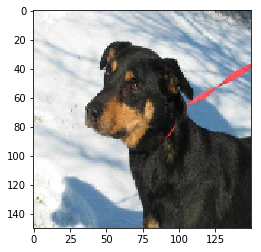

In [71]:
import os
import numpy as np
from keras.preprocessing import image
import matplotlib.pyplot as plt

data_path = os.getcwd()+'/dogs-vs-cats/train/dog.5000.jpg'

img = image.load_img(data_path,target_size = (150,150))
img = image.img_to_array(img)
img = np.expand_dims(img, axis = 0)/255


print(img.shape)

plt.figure()
plt.imshow(img[0])

#### Step2. 建立輸出

另外設置一組output來看看VGG16的輸出

In [3]:
from keras import models

#out_put= [layers.output for layers in model_vgg.layers[0:8]]

out_put = [model_vgg.get_layer('block1_conv2').output,
           model_vgg.get_layer('block2_conv2').output,
           model_vgg.get_layer('block3_conv2').output,
           model_vgg.get_layer('block4_conv2').output,]

activate_model = models.Model(inputs = model_vgg.input, outputs = out_put )

利用這個模型來把我們剛剛處理過的圖像丟入

In [4]:
result_act = activate_model.predict(img)

查看一下內容

隨意檢查其中一組output的其中一組通道

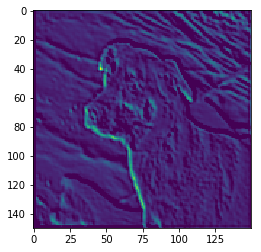

In [5]:
plt.figure()
plt.imshow(result_act[0][0,:,:,5])

這看起來像是抓取邊框

#### Step3. 把所有內容通道都印出來看看

C:\Users\a2720\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


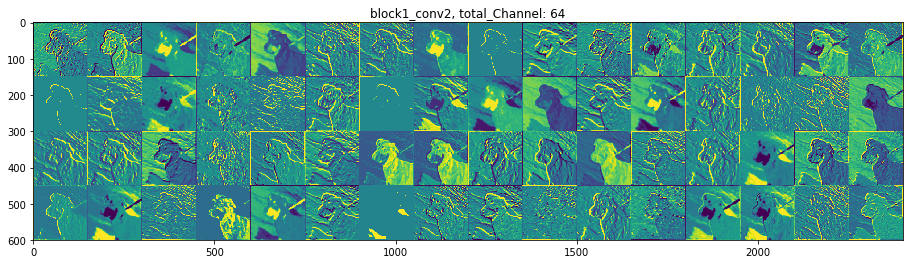

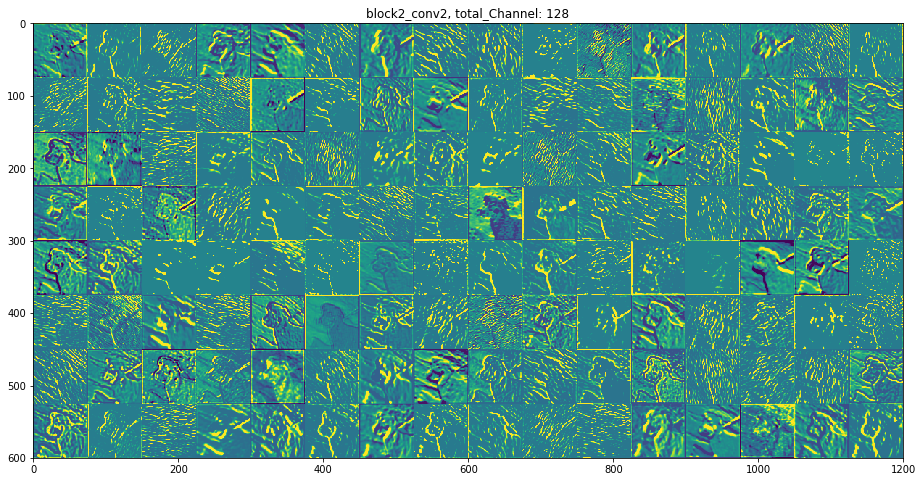

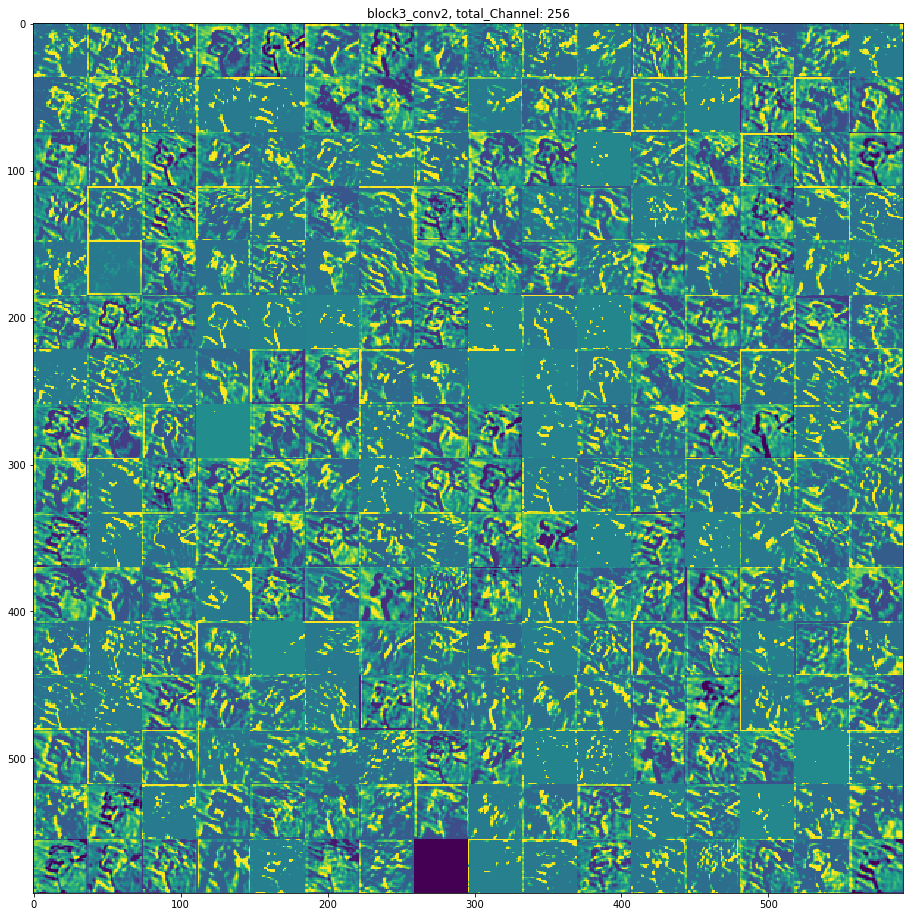

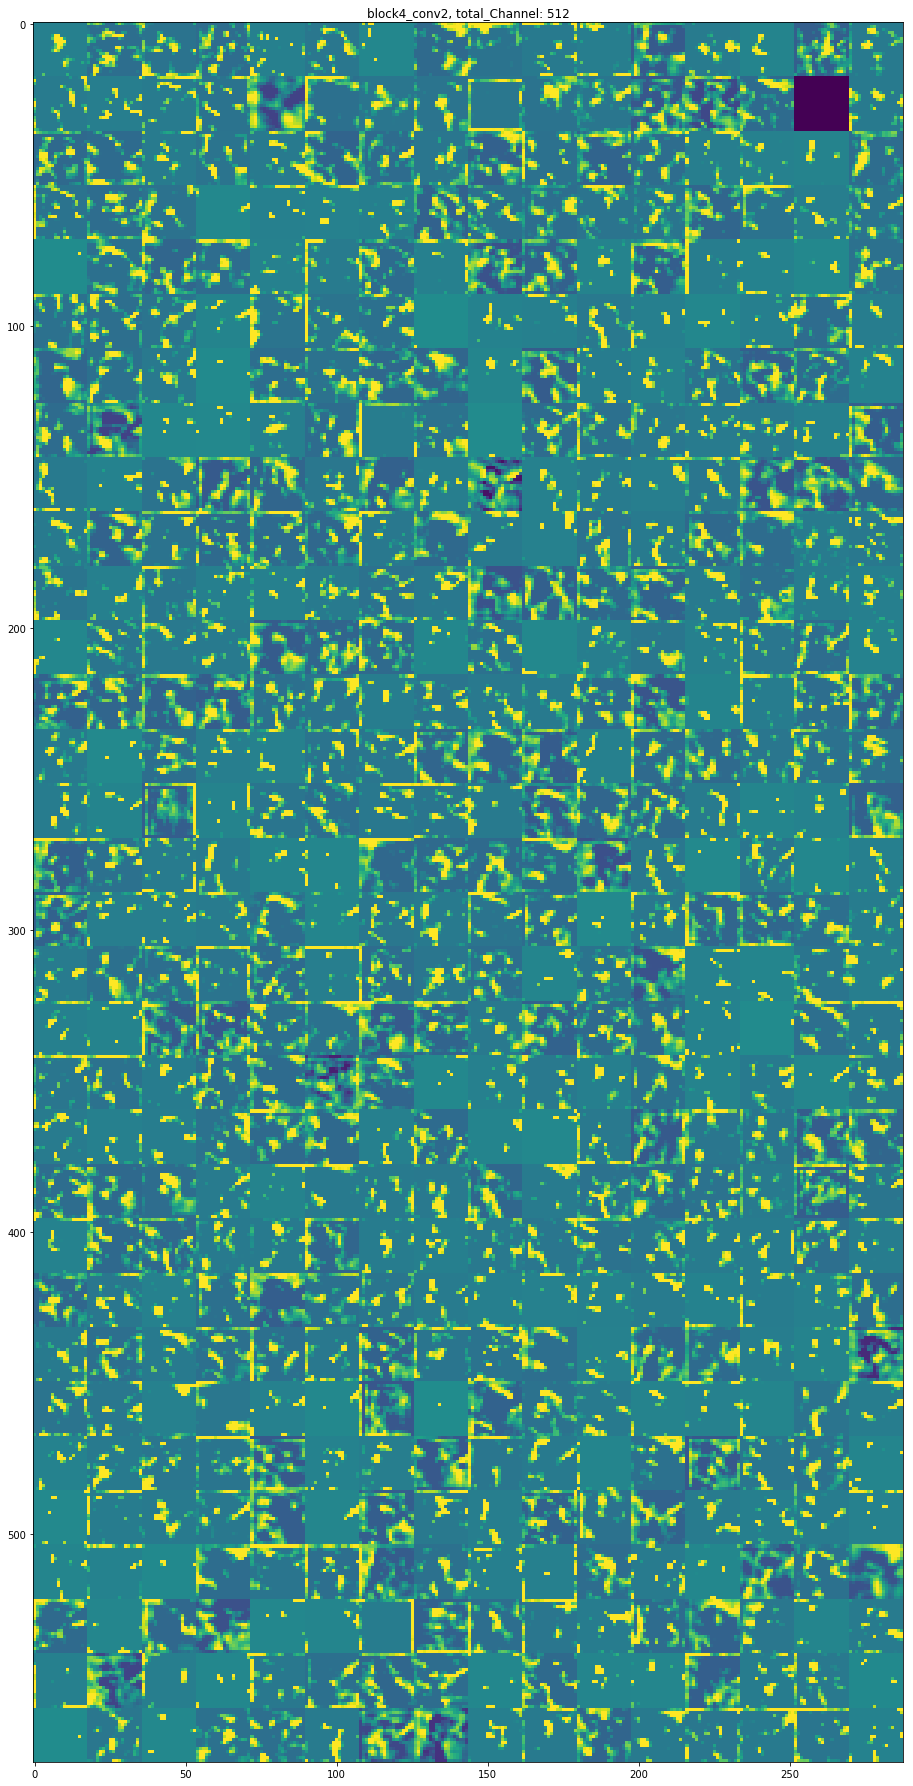

In [6]:
layer_names = ['block1_conv2','block2_conv2','block3_conv2','block4_conv2']

img_per_row = 16

for layer_name , img in zip(layer_names, result_act):
    
    number_image = img.shape[-1]
    size = img.shape[1]
    total_row = number_image // img_per_row
    display_img = np.zeros((size*total_row,size*img_per_row))
    
    
    for i in range(number_image):
        channel_img = img[0,:,:,i]
        channel_img -= channel_img.mean()
        channel_img /= channel_img.std()
        channel_img *= 64
        channel_img += 128
        channel_img = np.clip(channel_img, 0, 255).astype('uint8')
        
        row = int(i/img_per_row)
        col = int(i%img_per_row)
        display_img[row*size:(row+1)*size,col*size:(col+1)*size] = channel_img
    
    scale=1./size
    plt.figure(figsize=(display_img.shape[1]*scale,display_img.shape[0]*scale))
    plt.imshow(display_img ,  cmap='viridis')
    plt.title(layer_name+', total_Channel: '+ str(number_image))

plt.show()
    

更後面的卷積層所認知的越抽象，其中空白的部分代表該神經元對圖形沒有激勵(認知)

## Part 2. 卷積過濾器視覺化

通過自訂損失函數與輸入一張圖片讓每個神經元做gradian ascend來看看該神經元對什麼樣的圖形最敏感  
其代表意義可看作是該神經元負責過濾什麼樣的圖形

一樣利用VGG16來做
一個視覺化圖形需要經過:
* 損失函數: 利用keras backend來定義一組損失函數
* 梯度爬升: 利用keras backend的Gradiant來獲得梯度  

來獲得我們想要的結果

In [16]:
def process(x):
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    x += 0.5
    x = np.clip(x, 0, 1)

    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [24]:
from keras import backend as K
def generate_img(layer,filter):
    output = model_vgg.get_layer(layer).output 
    
    loss = K.mean(output[:,:,:,filter])
    gradiant = K.gradients(loss, model_vgg.input)[0]
    gradiant /= (K.sqrt(K.mean(K.square(gradiant))) + 1e-5)
    
    iterate = K.function([model_vgg.input], [loss, gradiant])
    
    initial_img = np.random.rand(1,150,150,3)
    
    arpha=1.
    for i in range(30):
        loss , grad = iterate([initial_img])
        initial_img += grad*arpha
        
    return initial_img[0]

測試結果

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


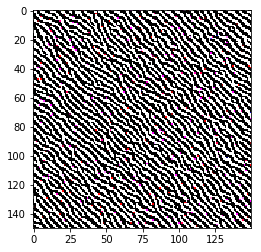

In [25]:
plt.imshow(generate_img('block1_conv2',30))

各層的output都印出來看看結果

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


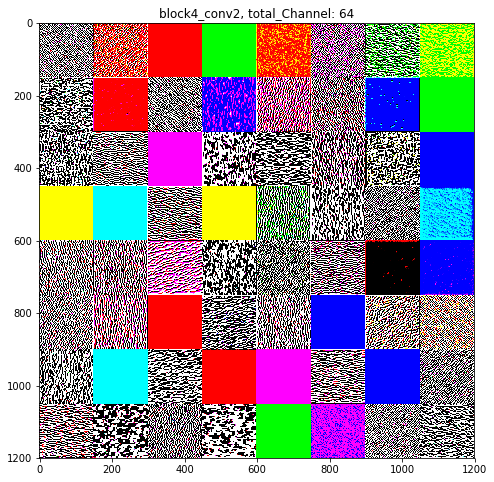

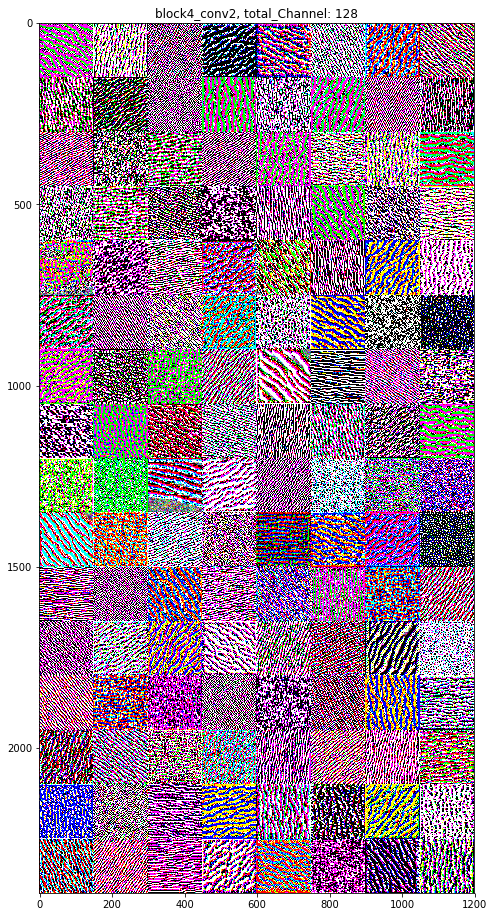

In [26]:
layer_names = ['block1_conv2','block2_conv2']
img_per_row =8

for layer in layer_names:
    output = model_vgg.get_layer(layer).output
    
    number_image = int(output.shape[-1])
    size = 150
    total_row = number_image // img_per_row
    display_img = np.zeros((size*total_row,size*img_per_row,3))
    
    
    for i in range(number_image):    
        row = int(i/img_per_row)
        col = int(i%img_per_row)
        display_img[row*size:(row+1)*size,col*size:(col+1)*size,:] = generate_img(layer,i)
    
    scale=1./size
    plt.figure(figsize=(display_img.shape[1]*scale,display_img.shape[0]*scale))
    plt.imshow(display_img)
    plt.title(layer_name+', total_Channel: '+ str(number_image))

plt.show()

## Part 3. 熱力圖

利用最後一層的卷積輸出與分類層的結果算出權重後  
把激勵的結果疊合到原圖上來看模型對於圖片的識別區域  


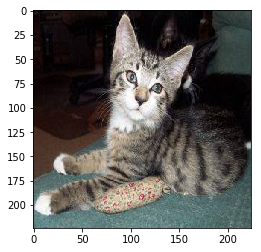

(1, 224, 224, 3)


In [110]:
from keras.applications.vgg16 import decode_predictions , preprocess_input

#model = VGG16(weights='imagenet')
data_path= os.getcwd()+'/dogs-vs-cats/train/cat.186.jpg'
imgs = image.load_img(data_path,target_size = (224,224,3))
imgs = image.img_to_array(imgs)
plt.imshow(imgs/255)
plt.show()
imgs = np.expand_dims(imgs, axis = 0)
print(imgs.shape)



In [111]:
imgs = preprocess_input(imgs)
result = model.predict(imgs)
print('Predicted:', decode_predictions(result))

Predicted: [[('n02124075', 'Egyptian_cat', 0.7821181), ('n02123045', 'tabby', 0.16400042), ('n02123159', 'tiger_cat', 0.039907742), ('n02127052', 'lynx', 0.006515444), ('n04074963', 'remote_control', 0.0007185206)]]


In [112]:
print(result.shape) # 由於Imagenet有1000種類別, 因此經過softmax之後會有1000個output

np.argmax(result[0]) # 我們看一下其中最大的值是那一個output

(1, 1000)


285

In [113]:
# 這是預測"african elephant"的那個產出的vector
tabby = model.output[:, 281]

# `block5_conv3`是VGG16模型中數個卷積層的最後一層, 我們想取出它所產出的特徵圖(feature map)
last_conv_layer = model.get_layer('block5_conv3')

# 我們計算"african elephant"經過`block5_conv3`的gradient
grads = K.gradients(tabby, last_conv_layer.output)[0]

# 這是一個shape(512,)的vector, 每一個點都代表每一個特徵圖的gradient的平均強度
pooled_grads = K.mean(grads, axis=(0, 1, 2))

# 這個功能允許我們訪問我們剛剛定義的數量的值
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

# 讓我們去計算輸入圖像後的損失張量(loss)和梯度張量(gradient)的值
pooled_grads_value, conv_layer_output_value = iterate([imgs])

# 我們將特徵圖中的每個通道乘以“這個通道有多重要”
for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

# 得到的特徵圖的通道平均值就是類別被激活的熱圖
heatmap = np.mean(conv_layer_output_value, axis=-1)

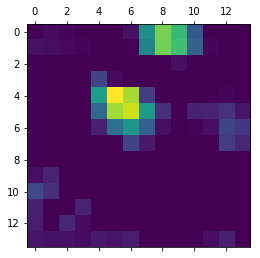

(14, 14)

In [114]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)
plt.show() # 秀出熱力圖

heatmap.shape # 資料的shape

In [1]:
import cv2

# 使用opencv來載入原始圖像
img = cv2.imread(data_path)

# 修改headmap的圖像大小來跟原始圖像一樣大
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

# 轉換heatmap成為的每一個cell值到一個0~256像素值的範圍
heatmap = np.uint8(255 * heatmap)

# 把heatmap疊加到原始圖像上
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

# 0.4 是一個heatmap的intensity factor
superimposed_img = heatmap * 0.3 + img

# 把處理過的圖像儲存起來
#cv2.imwrite('cat.jpg', superimposed_img)
plt.imshow(superimposed_img)

NameError: name 'data_path' is not defined